In [84]:
import sys
sys.path.append('/home/david/python/voltrad1')

import run_analytics as ra
import pandas as pd
import numpy as np
import datetime as dt
from pandas import ExcelWriter
from scipy import stats
import datetime as dt
# Analizar TIC activas para un subyacente y vencimiento dados para una datetime de valoracion dada
#   1.- se obtiene del chain option del h5 historico para la datetime de valoracion, los precios (opciones y subyacente),
#       IV, griegas, volumenes, OI,...
#       se le proporciona un date de valoracion y el datetime de valoracion corresponde a la ultima hora disponible para ese date
#       (hora_max)
#   2.- se obtiene lo mismo para (datetime de valoracion) - (1 dia)
#   3.- se obtiene la foto de las posiciones a datetime de valoración
#   4.- se obtiene todas las operaciones desde el inicio de la estrategia hasta el datetime de valoracion
#   5.- se obtiene del h5 account los impactos (deltas) en Cash (comisiones, primas cobradas) y margin en cada uno de los datetimes
#       en que se ha realizado operaciones (este historico se obtiene en el punto 4 anterior)
#
i_symbol='SPY'
i_year=2016
i_month_num=9
i_day_t0=20
i_day_tminus1=19
i_expiry='20161021'
i_secType='OPT' #OPT para SPY FOP para ES
fecha_valoracion=dt.datetime(year=i_year,month=i_month_num,day=i_day_t0)
i_month=fecha_valoracion.strftime("%B")[:3]
posiciones=ra.extrae_portfolio_positions(year=i_year,month=i_month,day=i_day_t0,symbol=i_symbol,expiry=i_expiry,secType=i_secType)
operaciones=ra.extrae_detalle_operaciones(year=i_year,month=i_month,day=i_day_t0,symbol=i_symbol,expiry=i_expiry,secType=i_secType)
cadena_opcs=ra.extrae_options_chain(year=i_year, month=i_month, day=i_day_t0,symbol=i_symbol,expiry=i_expiry,secType=i_secType)
cadena_opcs_tminus1=ra.extrae_options_chain(year=i_year, month=i_month, day=i_day_tminus1,symbol=i_symbol,expiry=i_expiry,secType=i_secType)
account=ra.extrae_account_snapshot_new(year=i_year, month=i_month_num, day=i_day_t0)
account=account.append(ra.extrae_account_snapshot_new(year=i_year, month=i_month_num, day=i_day_tminus1))
#writer = ExcelWriter('shark.xlsx')
#posiciones.to_excel(writer,sheet_name='posiciones',)
#operaciones.to_excel(writer, sheet_name='operaciones')
#cadena_opcs.to_excel(writer, sheet_name='cadena_opcs')
#account.to_excel(writer, sheet_name='account')
#writer.save()

In [85]:
operaciones

,account,avgprice,clientid,comboLegsDescrip,combolegs,conId,current_date,current_datetime,evmultiplier,evrule,...,qty,right,secId,secIdType,shares,side,strike,symbol,times,underComp
00012061.57e03c8d.02.01,DU242089,0.72,0,,None,237607006,20160919,20160919214106,0.0,,...,3,P,,,3,SLD,200.0,SPY,20160919 21:29:17,None
00012061.57e03c8d.03.01,DU242089,0.43,0,,None,237606986,20160919,20160919214106,0.0,,...,3,P,,,3,BOT,195.0,SPY,20160919 21:29:17,None
00012061.57e03c90.02.01,DU242089,0.729,0,,None,237607006,20160919,20160919214106,0.0,,...,30,P,,,27,SLD,200.0,SPY,20160919 21:29:22,None
00012061.57e03c90.03.01,DU242089,0.439,0,,None,237606986,20160919,20160919214106,0.0,,...,30,P,,,27,BOT,195.0,SPY,20160919 21:29:22,None
00012061.57e03c92.02.01,DU242089,0.04,0,,None,237606550,20160919,20160919214106,0.0,,...,30,C,,,30,BOT,228.0,SPY,20160919 21:36:26,None
00012061.57e03c92.03.01,DU242089,0.15,0,,None,237606530,20160919,20160919214106,0.0,,...,30,C,,,30,SLD,223.0,SPY,20160919 21:36:26,None


In [80]:
# sacar el precio del subyacente mas probable (la moda del lastUndPrice por cada load_dttm)
# para cada load_dttm debe haber pequeñas diferencias en el precio del subyacente por el modo asincrono en que se recuperan los datos.
underl_prc_df = cadena_opcs[['lastUndPrice','load_dttm']].groupby(['load_dttm']).agg(lambda x: stats.mode(x)[0][0])
underl_prc = float(underl_prc_df.ix[np.max(underl_prc_df.index)]['lastUndPrice'])
hora_max=np.max(underl_prc_df.index)

## Lo mismo pero para t-1 (ayer)
underl_prc_df_tminus1 = cadena_opcs_tminus1[['lastUndPrice','load_dttm']].groupby(['load_dttm']).agg(lambda x: stats.mode(x)[0][0])
underl_prc_tminus1 = float(underl_prc_df_tminus1.ix[np.max(underl_prc_df_tminus1.index)]['lastUndPrice'])
hora_max_tminus1=np.max(underl_prc_df_tminus1.index)

In [81]:
# calcular el retorno del subyacente entre el cierre de ayer y lo que llevamos de hoy
retorno_suby_dia = np.log(float(underl_prc_df[underl_prc_df.index == hora_max]['lastUndPrice']) 
       / float(underl_prc_df_tminus1[underl_prc_df_tminus1.index == hora_max_tminus1]['lastUndPrice'] ) )

In [82]:
# recupero la ultima cadena de opciones disponible para el subyacente y vencimiento dados en el datetime de valoracion 
#cadena_opcs.columns
cadena_opcs[[u'CallOI',u'PutOI', u'Volume', u'askDelta', u'askGamma',
       u'askImpliedVol', u'askOptPrice', u'askPrice', u'askPvDividend',
       u'askSize', u'askTheta', u'askUndPrice', u'askVega', u'bidDelta',
       u'bidGamma', u'bidImpliedVol', u'bidOptPrice', u'bidPrice',
       u'bidPvDividend', u'bidSize', u'bidTheta', u'bidUndPrice', u'bidVega',
       u'closePrice', u'highPrice', u'lastDelta', u'lastGamma', u'lastImpliedVol',
       u'lastOptPrice', u'lastPrice', u'lastPvDividend', u'lastSize',
       u'lastTheta', u'lastUndPrice', u'lastVega', u'lowPrice',
       u'modelDelta', u'modelGamma', u'modelImpliedVol', u'modelOptPrice',
       u'modelPvDividend', u'modelTheta', u'modelUndPrice', u'modelVega',
       u'multiplier', u'strike']] = cadena_opcs[[u'CallOI',u'PutOI', u'Volume', u'askDelta', u'askGamma',
       u'askImpliedVol', u'askOptPrice', u'askPrice', u'askPvDividend',
       u'askSize', u'askTheta', u'askUndPrice', u'askVega', u'bidDelta',
       u'bidGamma', u'bidImpliedVol', u'bidOptPrice', u'bidPrice',
       u'bidPvDividend', u'bidSize', u'bidTheta', u'bidUndPrice', u'bidVega',
       u'closePrice', u'highPrice', u'lastDelta', u'lastGamma', u'lastImpliedVol',
       u'lastOptPrice', u'lastPrice', u'lastPvDividend', u'lastSize',
       u'lastTheta', u'lastUndPrice', u'lastVega', u'lowPrice',
       u'modelDelta', u'modelGamma', u'modelImpliedVol', u'modelOptPrice',
       u'modelPvDividend', u'modelTheta', u'modelUndPrice', u'modelVega',
       u'multiplier', u'strike']].apply(pd.to_numeric)

cadena_opcs['load_dttm'] = cadena_opcs['load_dttm'].apply(pd.to_datetime) 
cadena_opcs = cadena_opcs[cadena_opcs['load_dttm'] == hora_max]
#cadena_opcs.info()
cadena_opcs.index = pd.RangeIndex(start=0, stop=len(cadena_opcs), step=1)
cadena_opcs=cadena_opcs.dropna(subset=['askDelta'])

In [83]:
#cadena_opcs=cadena_opcs.drop_duplicates(subset=['strike','symbol','secType','right','load_dttm','expiry',
#                                       'current_date','currency','exchange'])
#cadena_opcs.to_excel('cadena_opcs.xlsx')
cadena_opcs[cadena_opcs['strike'] == 206]

,CallOI,Halted,PutOI,Volume,askDelta,askGamma,askImpliedVol,askOptPrice,askPrice,askPvDividend,...,modelOptPrice,modelPvDividend,modelTheta,modelUndPrice,modelVega,multiplier,right,secType,strike,symbol
20,0.0,NaN,54406.0,20327.0,-0.106484,0.022944,0.355411,0.09,0.09,1.088346,...,0.021394,1.088346,-0.018947,216.64,0.008973,100,P,OPT,206.0,SPY
71,25358.0,NaN,0.0,84.0,0.908395,0.019839,0.374596,10.73,10.72,1.088346,...,10.600784,1.088346,-0.012699,216.58,0.005483,100,C,OPT,206.0,SPY


In [58]:
# saca los strikes mas cerca de ATM de la cadena de opciones del paso anterior
subset_df=cadena_opcs.ix[(cadena_opcs['strike'] - underl_prc).abs().argsort()[:4]]
# cadena_opcs[(cadena_opcs['strike']-underl_prc).abs() < 0.5]

# mejor usar modelImpliedVol que lastImpliedVol ???!!!

In [59]:
#calcula la volimpl del subyacente como las medias de las vol impl de las opciones mas ATM
impl_vol_suby = subset_df['modelImpliedVol'].mean()

In [60]:
# se obtienen todas operaciones desde el inicio de la estrategia hasta el datetime de valoracion
ops=operaciones[['localSymbol','avgprice','expiry','conId','current_datetime','symbol','load_dttm',
                 'multiplier','price','qty','right','side','strike','times']]
ops[['avgprice','multiplier','price','qty','strike']]=ops[['avgprice','multiplier','price','qty','strike']].apply(pd.to_numeric)

ops[['expiry','current_datetime','load_dttm','times']] = ops[['expiry','current_datetime','load_dttm','times']].apply(pd.to_datetime) 
#operaciones.columns
#operaciones.index
# elimina duplicados causados por posibles recargas manuales de los ficheros h5 desde IB API
ops=ops.reset_index().drop_duplicates(subset='index',keep='last')
ops=ops.set_index('index')

In [61]:
# se obtiene la lista de todas las datetimes en que se han realizado operaciones
temp_ts1=ops.reset_index().set_index('times').tz_localize('Europe/Madrid')
oper_series1=temp_ts1.index.unique()

In [62]:
# Enriquezco las posiciones desde el inicio con las quotes de la cadena de opciones IV, griegas precio del subyacente etc 
# en cada date de todas las operaciones que se han realizado desde el inicio de la estrategia
lista_dias = set([x.date() for x in oper_series1])
lista_dias
cadena_opcs2= pd.DataFrame()
for x in lista_dias:
    temporal1 =ra.extrae_options_chain(year=x.year, month=x.strftime("%B")[:3], 
                                       day=x.day,symbol=i_symbol,expiry=i_expiry,secType=i_secType)
    cadena_opcs2=cadena_opcs2.append(temporal1)
#cadena_opcs2
#cadena_opcs2.to_excel("cadena_opcs2.xlsx")

In [63]:
# devuelve en ops_w_hist_opt_chain la lista de operaciones historicas con las cotizaciones de la cadena de opciones incluida

cadena_opcs2[[u'CallOI',u'PutOI', u'Volume', u'askDelta', u'askGamma',
       u'askImpliedVol', u'askOptPrice', u'askPrice', u'askPvDividend',
       u'askSize', u'askTheta', u'askUndPrice', u'askVega', u'bidDelta',
       u'bidGamma', u'bidImpliedVol', u'bidOptPrice', u'bidPrice',
       u'bidPvDividend', u'bidSize', u'bidTheta', u'bidUndPrice', u'bidVega',
       u'closePrice', u'highPrice', u'lastDelta', u'lastGamma', u'lastImpliedVol',
       u'lastOptPrice', u'lastPrice', u'lastPvDividend', u'lastSize',
       u'lastTheta', u'lastUndPrice', u'lastVega', u'lowPrice',
       u'modelDelta', u'modelGamma', u'modelImpliedVol', u'modelOptPrice',
       u'modelPvDividend', u'modelTheta', u'modelUndPrice', u'modelVega',
       u'multiplier', u'strike']] = cadena_opcs2[[u'CallOI',u'PutOI', u'Volume', u'askDelta', u'askGamma',
       u'askImpliedVol', u'askOptPrice', u'askPrice', u'askPvDividend',
       u'askSize', u'askTheta', u'askUndPrice', u'askVega', u'bidDelta',
       u'bidGamma', u'bidImpliedVol', u'bidOptPrice', u'bidPrice',
       u'bidPvDividend', u'bidSize', u'bidTheta', u'bidUndPrice', u'bidVega',
       u'closePrice', u'highPrice', u'lastDelta', u'lastGamma', u'lastImpliedVol',
       u'lastOptPrice', u'lastPrice', u'lastPvDividend', u'lastSize',
       u'lastTheta', u'lastUndPrice', u'lastVega', u'lowPrice',
       u'modelDelta', u'modelGamma', u'modelImpliedVol', u'modelOptPrice',
       u'modelPvDividend', u'modelTheta', u'modelUndPrice', u'modelVega',
       u'multiplier', u'strike']].apply(pd.to_numeric)

cadena_opcs2[['expiry','load_dttm']] = cadena_opcs2[['expiry','load_dttm']].apply(pd.to_datetime) 

cadena_opcs3=cadena_opcs2.rename(columns={'load_dttm':'times'})
#cadena_opcs3=cadena_opcs3.reset_index().set_index(['times','strike','right','expiry','symbol'])
#cadena_opcs3.info()
cadena_opcs3['on']=cadena_opcs3['times'].dt.strftime("%Y-%m-%d %H")

cadena_opcs3=cadena_opcs3.drop_duplicates(subset=['expiry', 'strike','symbol','right','on'],keep='last')

ops2=ops
#ops2=ops.reset_index().set_index(['times','strike','right','expiry','symbol'])
#ops2.info()
ops2['on']=ops2['times'].dt.strftime("%Y-%m-%d %H")
ops_w_hist_opt_chain = pd.merge(ops2, cadena_opcs3, how='left', on=['expiry', 'strike','symbol','right','on']) #.fillna(method='ffill')

In [64]:
# Para cada datetime en que se han realizado operaciones (variable oper_series1) se extraen de cadena_opcs2 los precios mas adecuados
# cruzar esta lista con las cotizacionon la IV

result2 = ops_w_hist_opt_chain[['localSymbol','avgprice','expiry','conId','current_datetime_x','symbol','lastUndPrice',
                                'modelImpliedVol','load_dttm',
                                'multiplier_x','price','qty','right','side','strike','times_x','times_y',
                                'bidPrice','askPrice','lastPrice','current_datetime_y',
                                'modelDelta','modelGamma','modelTheta','modelVega']]

result2= result2.rename(columns={'multiplier_x': 'multiplier',  'times_x':'times_ops',  'times_y':'times_opt_chain',
                                     'current_datetime_x':'current_datetime_ops','current_datetime_y':'current_datetime_chain',
                                     'load_dttm_x': 'load_dttm_operaciones'})

#result2[['avgprice','expiry','symbol','lastUndPrice','modelImpliedVol','price','qty','right','side','strike',
#         'times_ops','modelDelta','modelGamma','modelTheta','modelVega']]

#caclulo dias a expiracion en el trade
result2['DTE'] = (result2['expiry'] - result2['times_ops'] ).astype('timedelta64[D]').astype(int)
## hay que calcular aqui la IV de las opciones ATM en el momento del trade, se saca de la cadena de opciones
cadena_opcs2.index = cadena_opcs2[['strike','load_dttm','right']]

# es necesario calcular esto aperturado por load_dttm (aqui se calcula un valor para todas las fechas de operaciones)
# result2['ImplVolATM'] = cadena_opcs2.ix[(cadena_opcs2['strike'] - cadena_opcs2['lastUndPrice']).abs().argsort()[:16] ]['modelImpliedVol'].mean()
temp1=cadena_opcs2.ix[(cadena_opcs2['strike'] - cadena_opcs2['lastUndPrice']).abs().argsort()[:64] ][['load_dttm','modelImpliedVol']]
temp1=temp1.groupby(by=['load_dttm'])['load_dttm','modelImpliedVol'].mean()
temp1=temp1.rename(columns={'modelImpliedVol':'ImplVolATM'})
temp1=temp1.reset_index()
temp1['on']=temp1['load_dttm'].dt.strftime("%Y-%m-%d %H")

t_trade_summary=result2[['times_opt_chain','load_dttm','times_ops','localSymbol','lastUndPrice','avgprice','multiplier',
                       'qty','side','DTE','modelDelta','modelGamma','modelTheta','modelVega','strike']].drop_duplicates()

t_trade_summary['on']=t_trade_summary['times_opt_chain'].dt.strftime("%Y-%m-%d %H")
trade_summary = pd.merge(t_trade_summary, temp1, how='left', on=['on']) 

# calcular 1SD con el horizonte de dias DTE
trade_summary['1SD'] = trade_summary['lastUndPrice'] * trade_summary['ImplVolATM'] / (365.0/((trade_summary['DTE']) ) )**0.5
trade_summary['lastUndPrice_less1SD']=trade_summary['lastUndPrice'] - trade_summary['1SD']
trade_summary['lastUndPrice_plus1SD']=trade_summary['lastUndPrice'] + trade_summary['1SD']
trade_summary['DIT'] = (fecha_valoracion - result2['times_ops'] ).astype('timedelta64[D]').astype(int) # days in trade
trade_summary=trade_summary.rename(columns={'load_dttm_x':'load_dttm'})
trade_summary = trade_summary.drop('load_dttm_y', 1)
trade_summary = trade_summary.drop('on', 1)
trade_summary['sign'] = 0
trade_summary.loc[trade_summary['side'] == 'SLD', 'sign'] = -1
trade_summary.loc[trade_summary['side'] == 'BOT', 'sign'] = 1

trade_summary['CreditoBruto'] = trade_summary['avgprice'] * trade_summary['multiplier'] * trade_summary['qty'] * trade_summary['sign']

#esto es util para la fase de apertura
trade_summary['1SD15D'] = trade_summary['lastUndPrice'] * trade_summary['ImplVolATM'] / (365.0/((15.0) ) )**0.5
trade_summary['1SD21D'] = trade_summary['lastUndPrice'] * trade_summary['ImplVolATM'] / (365.0/((21.0) ) )**0.5

trade_summary=trade_summary.sort_values(by=['times_opt_chain', 'localSymbol'] , ascending=[False, True])

#trade_summary.to_excel('trade_summary.xlsx')
#trad#e_summary

In [65]:
#posiciones actuales en las opciones en el symbol y el expiry 
#print posiciones.columns
pos=posiciones[[u'averageCost',u'conId', u'expiry', u'localSymbol', u'marketPrice', u'marketValue',
       u'multiplier', u'position', u'realizedPNL',
       u'right', u'strike', u'symbol', u'unrealizedPNL', u'current_datetime',
       u'load_dttm']]
# se queda con la última foto cargada del dia (la h5 accounts se actualiza cada hora RTH)
pos=pos.reset_index().drop_duplicates(subset='index',keep='last').set_index('index')

In [66]:
pos['load_dttm'] = pos['load_dttm'].apply(pd.to_datetime) 
pos[[u'averageCost',u'marketPrice',
       u'marketValue', u'multiplier', u'position', u'realizedPNL', u'strike',
     u'unrealizedPNL']] = pos[[u'averageCost',u'marketPrice',
       u'marketValue', u'multiplier', u'position', u'realizedPNL', u'strike',
     u'unrealizedPNL']].apply(pd.to_numeric)

In [67]:
pos

,averageCost,conId,expiry,localSymbol,marketPrice,marketValue,multiplier,position,realizedPNL,right,strike,symbol,unrealizedPNL,current_datetime,load_dttm
index,,,,,,,,,,,,,,,
178764651,45.725275,178764651,20160916,SPY 160916C00220000,0.056004,-44.80,100,-8,0.0,C,220.0,SPY,321.00,20160912204205,2016-09-12 20:42:00
178959074,48.585533,178959074,20160916,SPY 160916C00225000,0.010000,-12.00,100,-12,0.0,C,225.0,SPY,571.03,20160912204205,2016-09-12 20:42:00
178959079,18.411400,178959079,20160916,SPY 160916C00230000,0.002331,4.66,100,20,0.0,C,230.0,SPY,-363.57,20160912204205,2016-09-12 20:42:00
225023452,52.781700,225023452,20160916,SPY 160916P00206000,0.088655,177.31,100,20,0.0,P,206.0,SPY,-878.32,20160912204205,2016-09-12 20:42:00
225024492,62.214925,225024492,20160916,SPY 160916P00208000,0.125197,-250.39,100,-20,0.0,P,208.0,SPY,993.90,20160912204205,2016-09-12 20:42:00


In [68]:
# juntar las posiciones con la cadena de opciones para tener las griegas, bid ask volumen etc
# el datetime de los dos conjutnos de datos tiene siempre un lag por ese motivo el market value de pos
# no coincide con el last price que vienen de cadena_opcs
result = pd.merge(pos, cadena_opcs, how='left', on=['expiry', 'strike','symbol','right'])
result = result[['localSymbol','right','position','bidPrice','askPrice','lastPrice','marketValue','averageCost','multiplier_x',
                'modelDelta','modelGamma','modelTheta','modelVega','load_dttm_y','load_dttm_x','modelImpliedVol'
                 ,'expiry','lastUndPrice']]

result['expiry'] = result['expiry'].apply(pd.to_datetime) 
result.rename(columns={'multiplier_x': 'multiplier', 'load_dttm_y': 'load_dttm_cadena'
                      , 'load_dttm_x': 'load_dttm_posiciones'}, inplace=True)
"""
u'averageCost', u'conId', u'expiry', u'localSymbol', u'marketPrice',
       u'marketValue', u'multiplier_x', u'position', u'realizedPNL', u'right',
       u'strike', u'symbol', u'unrealizedPNL', u'current_datetime_x',
       u'load_dttm_x', u'CallOI', u'Halted', u'PutOI', u'Volume', u'askDelta',
       u'askGamma', u'askImpliedVol', u'askOptPrice', u'askPrice',
       u'askPvDividend', u'askSize', u'askTheta', u'askUndPrice', u'askVega',
       u'bidDelta', u'bidGamma', u'bidImpliedVol', u'bidOptPrice', u'bidPrice',
       u'bidPvDividend', u'bidSize', u'bidTheta', u'bidUndPrice', u'bidVega',
       u'closePrice', u'currency', u'current_date', u'current_datetime_y',
       u'exchange', u'highPrice', u'lastDelta', u'lastGamma',
       u'lastImpliedVol', u'lastOptPrice', u'lastPrice', u'lastPvDividend',
       u'lastSize', u'lastTheta', u'lastUndPrice', u'lastVega', u'load_dttm_y',
       u'lowPrice', u'modelDelta', u'modelGamma', u'modelImpliedVol',
       u'modelOptPrice', u'modelPvDividend', u'modelTheta', u'modelUndPrice',
       u'modelVega', u'multiplier_y', u'secType'
"""

#caclulo dias a expiracion en el trade
result['DTE'] = (result['expiry'] - fecha_valoracion ).astype('timedelta64[D]').astype(int)
## hay que calcular aqui la IV de las opciones ATM en el momento del trade, se saca de la cadena de opciones
result['ImplVolATM'] = cadena_opcs.ix[(cadena_opcs['strike'] - cadena_opcs['lastUndPrice']).abs().argsort()[:4] ]['modelImpliedVol'].mean()
# calcular 1SD con el horizonte de dias DTE
result['1SD'] = result['lastUndPrice'] * result['ImplVolATM'] / (365.0/((result['DTE']) ) )**0.5
result['lastUndPrice_less1SD']=result['lastUndPrice'] - result['1SD']
result['lastUndPrice_plus1SD']=result['lastUndPrice'] + result['1SD']
result['midPrice']= ( result['bidPrice'] + result['askPrice'] ) / 2
result['ValCurrent'] = result['midPrice'] * np.sign(result['position'])
result['costUnit'] = result['averageCost'] * np.sign(result['position']) / result['multiplier']
result['Dshort'] = result['modelDelta'] * result['multiplier']
result['DshortPosition'] = result['modelDelta'] * result['multiplier'] * result['position']
result['GammaPosition'] = result['modelGamma'] * result['multiplier'] * result['position']
result['ThetaPosition'] = result['modelTheta'] * result['multiplier'] * result['position']
result['VegaPosition'] = result['modelVega'] * result['multiplier'] * result['position']
positions_summary=result
positions_summary=positions_summary.sort_values(by=['right', 'localSymbol'] , ascending=[False, True])
#positions_summary.to_excel('positions_summary.xlsx')

In [64]:
# agregar por spreads
spread_summary = result.groupby(by=['right'])['ValCurrent','costUnit','marketValue','DshortPosition'].sum()
#print spread_summary

#print "__________"
# agregar total
total_summary = result[['DshortPosition','GammaPosition','ThetaPosition','VegaPosition','marketValue']].sum()
total_summary_risk = result[['lastUndPrice','ImplVolATM','multiplier']].mean()
total_summary_risk['Pts1SD1D'] = total_summary_risk['lastUndPrice'] * total_summary_risk['ImplVolATM'] / np.sqrt(365)
total_summary_risk['Pts1SD5D'] = total_summary_risk['lastUndPrice'] * total_summary_risk['ImplVolATM'] / np.sqrt(365/5)
total_summary=total_summary.append(total_summary_risk)

#print total_summary

In [65]:
# impacto en el margen de la operacion
# recibimos el date time que corresponde al time en que se hizo la lista de operaciones y que viene del dataframe
# operaciones y se calcula la delta del margen en la cuenta. Las fechas de los snapshots de account será los dos más cercanos
# de los que se disponga en el h5 accounts (este fichero se actualiza cada hora durante RTH)
# si  en eseintervalo de tiempo se hiciesen operaciones en otros symbol-expirations el resultado de aqui sería incorrecto
# lo esperable es que el margen sea igual a la diferencia entre los strikes del spread del iron condor mas ancho
#ops.reset_index().drop_duplicates(subset='index',keep='last').set_index('index')
#ops
temp_margin=pd.DataFrame()
temp_premium=pd.DataFrame()
for x in oper_series1:
    #temporal1 =ra.extrae_account_delta_new(year=x.year, month=x.strftime("%B")[:3],day=x.day,hour=x.hour,minute=x.minute)
    temporal1 =ra.extrae_account_delta_new(year=x.year, month=x.month,day=x.day,hour=x.hour,minute=x.minute)
    temporal1['load_dttm'] = temporal1['current_datetime']
    temporal1=temporal1.set_index('load_dttm')
    t_margin=temporal1[['RegTMargin_USD','MaintMarginReq_USD','InitMarginReq_USD',
                            'FullMaintMarginReq_USD','FullInitMarginReq_USD']].apply(pd.to_numeric)
    t_margin.diff()
    t_margin['fecha_operacion']=str(x)
    temp_margin = temp_margin.append(t_margin)
    # cash primas y comisiones
    # impacto en comisiones de las operaciones
    # dado un datetime donde se han ejecutado operaciones hace la delta de las posiciones cash de la cuenta y eso 
    # resulta en el valor de las comisiones de ese conjunto de operaciones (hay que considerar el dienro recibido de)
    # la venta de opciones y tambien si se tiene posiciones en divisa los cambios ????
    t_prem =temporal1[['TotalCashBalance_BASE','TotalCashBalance_EUR','TotalCashBalance_USD','TotalCashValue_USD',
                      'CashBalance_EUR','CashBalance_USD','TotalCashValue_C_USD','TotalCashValue_S_USD',
                      'CashBalance_BASE','ExchangeRate_EUR']].apply(pd.to_numeric).diff()  
    t_prem['fecha_operacion']=str(x)
    temp_premium = temp_premium.append(t_prem)   

# por cada fecha de operacion tendremos cuatro registros tipicamente en la tabla temp_margin
# dos por cada spread de la tic (4 en total) y los dos por cada spread son el margen antes de la operacion
# y el margen despues. Dado que el margen que coge el broker en una tic es por un spread solo
#el margen incial final es para toda la cuenta, y si se resta da el efecto de la operacion
# como los snapshots de la cuenta son por cada hora, si se abre una tic completa (dos spreads) dentro de una
# misma hora aparecera el incremento del margen dos veces
# sin embargo por lo dicho antes si ya se tiene un spread de la tic abierto el otro no incrementa el margen
# a no ser que el ancho del nuevo spread sea mayor que el anterior. 

#writer = ExcelWriter('results1.xlsx')#
#temp_margin.to_excel(writer,sheet_name#='margin',)
#temp_premium.to_excel(writer, sheet_nam#e='premium')
#writer.save(#)

In [66]:
## Check values

x11=dt.datetime.strptime('2016-08-19 20:24:18','%Y-%m-%d %H:%M:%S')
kk=ra.extrae_account_delta_new(year=x11.year, month=x11.strftime("%B")[:3],day=x11.day,hour=x11.hour,minute=x11.minute)
kk[['current_datetime','RegTMargin_USD','MaintMarginReq_USD','InitMarginReq_USD',
                            'FullMaintMarginReq_USD','FullInitMarginReq_USD',
   'TotalCashBalance_BASE','TotalCashBalance_EUR','TotalCashBalance_USD','TotalCashValue_USD',
                      'CashBalance_EUR','CashBalance_USD','TotalCashValue_C_USD','TotalCashValue_S_USD',
                      'CashBalance_BASE','ExchangeRate_EUR']]

,current_datetime,RegTMargin_USD,MaintMarginReq_USD,InitMarginReq_USD,FullMaintMarginReq_USD,FullInitMarginReq_USD,TotalCashBalance_BASE,TotalCashBalance_EUR,TotalCashBalance_USD,TotalCashValue_USD,CashBalance_EUR,CashBalance_USD,TotalCashValue_C_USD,TotalCashValue_S_USD,CashBalance_BASE,ExchangeRate_EUR
AccountCode_,,,,,,,,,,,,,,,,
DU242089,20160830204206,6000.00,12502.00,14127.50,12502.00,14127.50,1008508,17802,988676,1008507.66,17802,988676,58730.14,949777.52,1008508,1.1140049


In [67]:
temp_margin=temp_margin.reset_index()[['load_dttm','RegTMargin_USD']].drop_duplicates()
temp_premium=temp_premium.reset_index()[['load_dttm','TotalCashValue_USD']].drop_duplicates()
temp_margin2=temp_margin.rename(columns={'RegTMargin_USD':'RegTMargin_USD_actual'})
temp_premium2=temp_premium.rename(columns={'TotalCashValue_USD':'Impacto_encash_ultimo_periodo1h'})
temp_premium2=temp_premium2.dropna()

temp_margin2['on']=pd.to_datetime(temp_margin2['load_dttm'], format="%Y%m%d%H%M%S")
temp_premium2['on']=pd.to_datetime(temp_premium2['load_dttm'], format="%Y%m%d%H%M%S")

temp_margin2['on'] = temp_margin2['on'].dt.strftime("%Y-%m-%d %H")
temp_premium2['on'] = temp_premium2['on'].dt.strftime("%Y-%m-%d %H")
 
temp_credbruto=trade_summary.groupby(by=['times_opt_chain'])['times_opt_chain','CreditoBruto'].sum()
temp_credbruto=temp_credbruto.reset_index()
temp_credbruto['on']=temp_credbruto['times_opt_chain'].dt.strftime("%Y-%m-%d %H")

trade_summary_margin_cash = pd.merge(temp_margin2, temp_premium2, how='left', on=['on']) 
trade_summary_margin_cash = pd.merge(trade_summary_margin_cash, temp_credbruto, how='left', on=['on']) 
trade_summary_margin_cash = trade_summary_margin_cash.drop('on', 1)
trade_summary_margin_cash = trade_summary_margin_cash.drop('load_dttm_y', 1)
trade_summary_margin_cash = trade_summary_margin_cash.drop('times_opt_chain', 1)
trade_summary_margin_cash=trade_summary_margin_cash.rename(columns={'load_dttm_x':'load_dttm'})
trade_summary_margin_cash['Comisiones'] = np.abs(trade_summary_margin_cash['Impacto_encash_ultimo_periodo1h'] + trade_summary_margin_cash['CreditoBruto'] ) 
trade_summary_margin_cash['Margen_neto'] = 0
trade_summary_margin_cash.loc[trade_summary_margin_cash['RegTMargin_USD_actual'] <= 0, 'Margen_neto'] = 0
trade_summary_margin_cash.loc[trade_summary_margin_cash['RegTMargin_USD_actual'] > 0, 'Margen_neto'] = trade_summary_margin_cash['RegTMargin_USD_actual'] - trade_summary_margin_cash['Impacto_encash_ultimo_periodo1h']

trade_summary_margin_cash['load_dttm']=pd.to_datetime(trade_summary_margin_cash['load_dttm'], format="%Y%m%d%H%M%S")

trade_summary_margin_cash['BeneficioMaximoPct'] = 0
trade_summary_margin_cash.loc[trade_summary_margin_cash['RegTMargin_USD_actual'] > 0, 'BeneficioMaximoPct'] = trade_summary_margin_cash['Impacto_encash_ultimo_periodo1h'] / trade_summary_margin_cash['Margen_neto'] 
trade_summary_margin_cash=trade_summary_margin_cash.sort_values(by='load_dttm')

#writer = ExcelWriter('trade_summary_margin_cash.xlsx')
#trade_summary_margin_cash.to_excel(writer,sheet_name='trade_summary_margin_cash')
#writer.save()

#trade_summary_margin_cash

In [68]:
# calcular apalancamientos de la posicion completa

# a continuacion es el margen neto que quedo tras la ultima operacion en la estrategia completa
cb_tot = trade_summary_margin_cash [(trade_summary_margin_cash['load_dttm']) ==trade_summary_margin_cash.reset_index().max()['load_dttm'] ]  ['Margen_neto']

total_summary['AD1PCT'] =np.abs( total_summary['multiplier'] * ( ( (np.abs(total_summary['DshortPosition']) + total_summary['GammaPosition'] ) 
                                                                   * total_summary['lastUndPrice'] / total_summary['multiplier'] ) - total_summary['GammaPosition'] )
                                                                / cb_tot ).values[0]


total_summary['AD1SD1D'] =np.abs( total_summary['multiplier'] * ( ( (np.abs(total_summary['DshortPosition']) + total_summary['GammaPosition'] ) 
                                                                   * total_summary['lastUndPrice'] * total_summary['ImplVolATM'] / np.sqrt(365) ) 
                                                                 - total_summary['GammaPosition'] ) / cb_tot ).values[0]

total_summary['MaxDsAD1PCT'] = np.abs ( 3 * total_summary['DshortPosition'] / total_summary['AD1PCT'] )
total_summary['MaxDsAD1SD1D'] = np.abs ( 3 * total_summary['DshortPosition'] / total_summary['AD1SD1D'] )
total_summary['MaxDs'] = np.abs ( 0.04 * cb_tot / total_summary['Pts1SD1D'] ).values[0]
total_summary['thetaDeltaRatio'] = np.abs ( total_summary['ThetaPosition'] / total_summary['DshortPosition'] )
total_summary['thetaGammaRatio'] = np.abs ( total_summary['ThetaPosition'] / total_summary['GammaPosition'] )
total_summary['VegaThetaRatio'] = np.abs ( total_summary['VegaPosition'] / total_summary['ThetaPosition'] )

#total_summary

In [69]:
## Resultado final 
# date time de los datos de option chain usados en los cálculos (hora_max)
# underly (todos los valores son a fecha de valoracion / fecha actual): 
#   fecha valoracion, ticker , last price, 
# trade (todos los valores son a fecha de la operacion):
#   fecha de operacion, impl vol, dias a expiracion
#print "____________________Precios del subyacente almancenados de la fecha de valoracion _____________"
#print underl_prc_df
#print "____________________Con las siguientes se calcula la IV del subyacente (las IV de las opciones P C mas ATM) _____________"
#print subset_df[['modelImpliedVol','strike','load_dttm','right']]
#print "---------------------------------------- underlying ----------------------------------------"
#print ({'hora max datos':hora_max, 'fecha valoracion':fecha_valoracion , 'subycente':i_symbol, 'precio last subyacente':underl_prc, 
#        'precio close anterior subyacente':underl_prc_tminus1, 'vol. implicita subyacente': impl_vol_suby ,'retorno subyacente': retorno_suby_dia})
#print "---------------------------------------- Sumario Trade TIC ----------------------------------------"
#print trade_summary # muestra el precio de subyacente en el momento de cada trade de la tic
#print "---------------------------------------- Sumario Posiciones TIC ----------------------------------------"
#print positions_summary
#print "---------------------------------------- Sumario Margin y Cash ----------------------------------------"
#print trade_summary_margin_cash 
#print "---------------------------------------- Sumario TIC por Spread  a fecha valoracion ----------------------------------------"
# resultados por spread de la TIC
#print spread_summary
#print "---------------------------------------- Sumario TIC global a fecha valoracion ----------------------------------------"
# resultados globales de la TIC
#print total_summary

sumario_subyacente = pd.DataFrame({'hora max datos':hora_max, 'fecha valoracion':fecha_valoracion , 'subycente':i_symbol, 'precio last subyacente':underl_prc, 
        'precio close anterior subyacente':underl_prc_tminus1, 'vol. implicita subyacente': impl_vol_suby ,'retorno subyacente': retorno_suby_dia},index=[0])


writer = ExcelWriter('dailyanalytics'+fecha_valoracion.strftime("%Y-%m-%d")+'.xlsx')
underl_prc_df.to_excel(writer,sheet_name='Precios Suby.')
subset_df[['modelImpliedVol','strike','load_dttm','right']].to_excel(writer,sheet_name='Calculo IV ATM')
sumario_subyacente.to_excel(writer,sheet_name='Sumario Suby.')
trade_summary.to_excel(writer,sheet_name='Sumario Trades')
positions_summary.to_excel(writer,sheet_name='Sumario Posiciones')
trade_summary_margin_cash.to_excel(writer,sheet_name='Sumario Margin Primas')
spread_summary.to_excel(writer,sheet_name='Sumario Spreads')
total_summary.to_frame(name='Conceptos').to_excel(writer,sheet_name='Sumario estrategia')
writer.save()

trade_summary=trade_summary.dropna()
writer = ExcelWriter('dailyanalytics.xlsx')
underl_prc_df.to_excel(writer,sheet_name='Precios Suby.')
subset_df[['modelImpliedVol','strike','load_dttm','right']].to_excel(writer,sheet_name='Calculo IV ATM')
sumario_subyacente.to_excel(writer,sheet_name='Sumario Suby.')
trade_summary.to_excel(writer,sheet_name='Sumario Trades')
positions_summary.to_excel(writer,sheet_name='Sumario Posiciones')
trade_summary_margin_cash.to_excel(writer,sheet_name='Sumario Margin Primas')
spread_summary.to_excel(writer,sheet_name='Sumario Spreads')
total_summary.to_frame(name='Conceptos').to_excel(writer,sheet_name='Sumario estrategia')
writer.save()

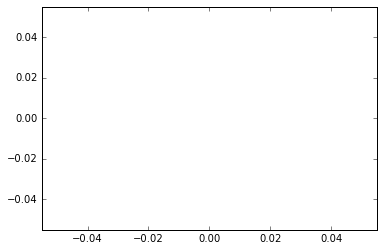

In [70]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

calls=cadena_opcs2[ (cadena_opcs2['right'] == 'C') & (cadena_opcs2['strike'] < 220.0) & (cadena_opcs2['strike'] > 190.0) ]
groups=calls.groupby('load_dttm')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.strike, group.modelOptPrice, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()